# Feature Refinement

**Concept:** This lesson takes you beyond Milestone 3’s feature basics. Now, you’ll use model performance, errors, and production feedback to drive feature improvement for real-world, business-critical systems.

Why This Matters:

- Models often fail in production due to hidden data issues, not poor algorithms.
- You need feedback loops: Model results can guide what features to improve, drop, or monitor.
- Milestone 3 taught you feature basics. Now, think: “how does my model behave with these features in real business scenarios?”

We use the top 4 models from evaluation notebook to evaluate feature importance and performance. We will also use the hyperparameters from the model optimization step (Grid Search).

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X_train = pd.read_csv("../data/processed/X_train.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_val = pd.read_csv("../data/processed/y_val.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

target_variable = "tree_type"

models = {
    "Logistic Regression": LogisticRegression(C=0.01, penalty='l2', solver='saga'),
    "Random Forest": RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_split=2, n_estimators=100),
    "SVM": SVC(C=100, gamma='auto', kernel='rbf'),
    "KNN": KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance'),
}

# Fit all the models
for name, model in models.items():
    model.fit(X_train, y_train[target_variable])
    score = model.score(X_val, y_val)
    print(f"{name} Validation Score: {score:.3f}")

Logistic Regression Validation Score: 0.849
Random Forest Validation Score: 0.909
SVM Validation Score: 0.898
KNN Validation Score: 0.915


## Print a confusion matrix

This helps us understand where the model is making mistakes.

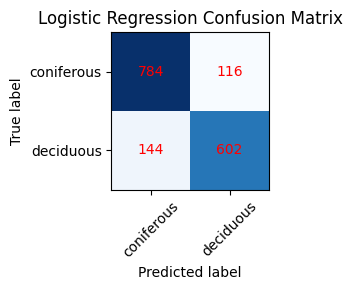

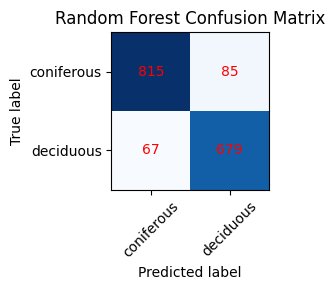

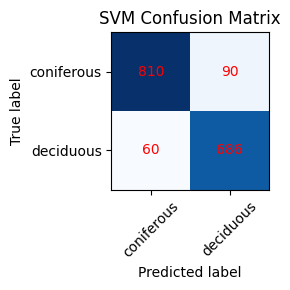

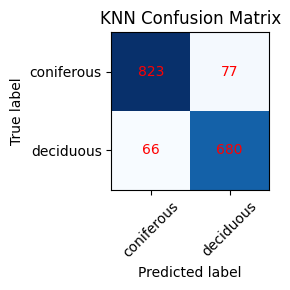

In [2]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    tick_marks = np.arange(len(np.unique(y_test[target_variable])))
    plt.xticks(tick_marks, np.unique(y_test[target_variable]), rotation=45)
    plt.yticks(tick_marks, np.unique(y_test[target_variable]))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="red")
    plt.tight_layout()
    plt.show()

## Print feature importance

This helps us understand which features are most influential in the model's predictions.

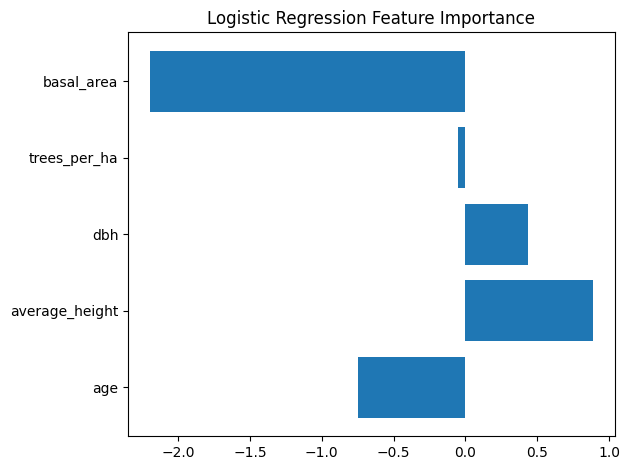

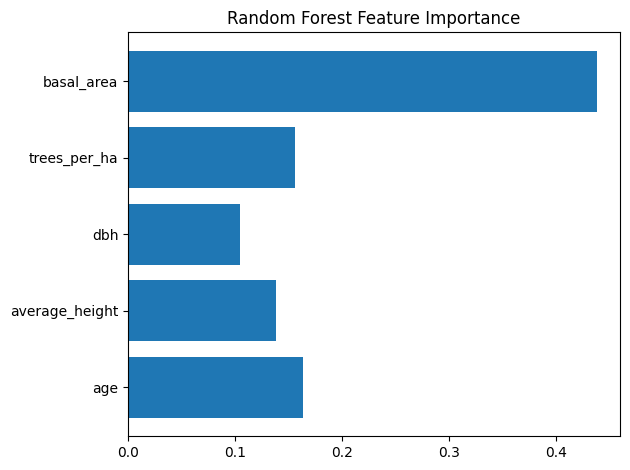

SVM does not support feature importances.
KNN does not support feature importances.


In [3]:

for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = X_train.columns
    elif hasattr(model, "coef_"):
        importances = model.coef_[0]
        feature_names = X_train.columns
    else:
        print(f"{name} does not support feature importances.")
        continue
    plt.barh(feature_names, importances)
    plt.title(f'{name} Feature Importance')
    plt.tight_layout()
    plt.show()

## Production-Scale Categorical Encoding Strategies

**Concept:** Basic label/one-hot encoding works for small categories but not for thousands of store IDs, products, etc. Production demands smarter, scalable encodings.

### When to Level Up:

- Does a feature have 100+ unique values? (E.g., zip code, product ID)
- Avoid one-hot—use target or frequency encoding instead.

As we don't meet one of these criteria, we will not implement these strategies in this project.

## Check if missing values predict the target

**Concept:** Missing values are more than gaps to fill. They're business signals! Why customers skip fields, when systems fail, and how missing patterns predict outcomes.

Recall basic imputation from Milestone 3 Lesson 3 before diving into business intelligence.

As we don't have missing values we don't need to consider that.

In [4]:
def missing_analysis(df, target_col):
    for col in df.columns:
        if df[col].isnull().any():
            missing_target_rate = df[df[col].isnull()][target_col].mean()
            present_target_rate = df[df[col].notnull()][target_col].mean()
            
            print(f"{col}: Missing={missing_target_rate:.2f}, Present={present_target_rate:.2f}")
            if abs(missing_target_rate - present_target_rate) > 0.1:
                print(f"  → {col} missingness is predictive!")

combined_df = pd.concat([X_train, y_train[target_variable]], axis=1)
missing_analysis(combined_df, target_variable)

## 